In [1]:
from mfbml.methods.mfrbfgp import MFRBFGPR
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mfpml.design_of_experiment.multifidelity_samplers import MFSobolSequence
from mfpml.models.gaussian_process import GaussianProcess
from mfpml.models.kernels import RBF
from mfpml.problems.multifidelity_functions import (
    Forrester_1c,
    Forrester_1a,
    Forrester_1b,
)
from scipy.linalg import cholesky, solve
from scipy.optimize import minimize

# import accuracy measures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
def calculate_log_marginal_likelihood_mf(model: MFRBFGPR, sample_x, sample_y):
    # get test data
    sample_scaled = model.normalize_input(sample_x)
    num_sample = sample_x.shape[0]
    f = model.predict_lf(sample_x)
    # get the kernel matrix
    K = model.kernel.get_kernel_matrix(
        sample_scaled, sample_scaled
    ) + model.noise**2 * np.eye(num_sample)

    L = cholesky(K, lower=True)

    # step 1: get the optimal beta
    # f, basis function
    # self.f = self.predict_lf(self.sample_xh)
    # alpha = K^(-1) * Y
    alpha = solve(L.T, solve(L, sample_y))
    # K^(-1)f
    KF = solve(L.T, solve(L, f))
    ld = cholesky(np.dot(f.T, KF), lower=True)
    # beta = (F^T *K^(-1)* F)^(-1) * F^T *R^(-1) * Y
    beta = solve(ld.T, solve(ld, np.dot(f.T, alpha)))

    # step 2: get the optimal sigma2
    gamma = solve(L.T, solve(L, (sample_y - np.dot(f, beta))))
    sigma2 = np.dot((sample_y - np.dot(f, model.beta)).T, gamma) / num_sample

    # step 3: get the optimal log likelihood
    logp = (-0.5 * num_sample * sigma2 - np.sum(np.log(np.diag(L)))).item()

    return logp

In [3]:
func = Forrester_1b()

noise_add1 = 0.3
num_hf_samples = 50
num_lf_samples = 200
optimizer_restart = 30
# define sampler
sampler = MFSobolSequence(design_space=func.design_space, seed=2)
sample_x = sampler.get_samples(
    num_hf_samples=num_hf_samples, num_lf_samples=num_lf_samples)

sample_y1 = {}
# get response
sample_y1["hf"] = func.hf(sample_x["hf"]) + np.random.normal(
    0, noise_add1, size=sample_x["hf"].shape[0]
).reshape(-1, 1)
sample_y1["lf"] = func.lf(sample_x["lf"]) + np.random.normal(
    0, noise_add1, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func.hf(test_x)
test_ly = func.lf(test_x)

# generate noisy test data test_x_noisy
test_x_noisy = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy_noisy = func.hf(test_x_noisy) + np.random.normal(
    0, noise_add1, size=test_x_noisy.shape[0]
).reshape(-1, 1)

In [4]:
# for developed methods
# start_time = time.time()
mfrbfgp1 = MFRBFGPR(
    design_space=func.input_domain, noise_prior=None, optimizer_restart=optimizer_restart
)
mfrbfgp1.train(samples=sample_x, responses=sample_y1)

mfrbfgp theta:  [58.89917578]
mfrbfgp beta:  [[0.55644885]]
mfrbfgp noise:  0.33247857324849295


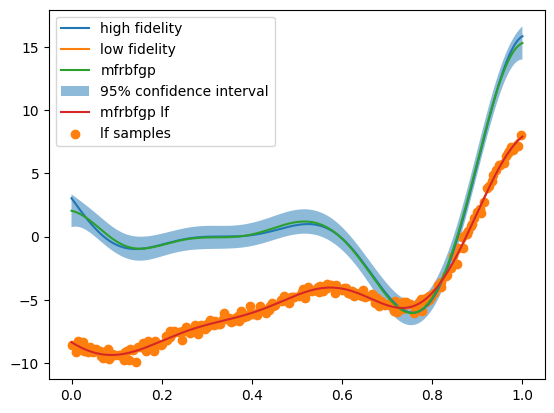

In [5]:
mfrbfgp_pred_y1, mfrbfgp_pred_std1 = mfrbfgp1.predict(
    x_predict=test_x, return_std=True)
# get prediction of low fidelity
pred_ly1 = mfrbfgp1.predict_lf(test_xl=test_x)

print("mfrbfgp theta: ", mfrbfgp1.kernel.param)
print("mfrbfgp beta: ", mfrbfgp1.beta)
print("mfrbfgp noise: ", mfrbfgp1.noise)
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y1, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y1 - 1.96 * mfrbfgp_pred_std1).flatten(),
    (mfrbfgp_pred_y1 + 1.96 * mfrbfgp_pred_std1).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly1, label="mfrbfgp lf")
ax.scatter(sample_x["lf"], sample_y1["lf"], label="lf samples")
# ax.scatter(sample_x["lf"], sample_y_1a["lf"], label="lf samples")
ax.legend()
plt.show()

In [6]:
# add more noise to the low fidelity
noise_add_2 = 0.5
sample_y2 = sample_y1.copy()
sample_y2["lf"] = func.lf(sample_x["lf"]) + np.random.normal(
    0, noise_add_2, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

In [7]:
# train the model
mfrbfgp2 = MFRBFGPR(
    design_space=func.input_domain, noise_prior=None, optimizer_restart=optimizer_restart
)
mfrbfgp2.train(samples=sample_x, responses=sample_y2)
mfrbfgp_pred_y2, mfrbfgp_pred_std2 = mfrbfgp2.predict(
    x_predict=test_x, return_std=True)
# get prediction of low fidelity
pred_ly2 = mfrbfgp2.predict_lf(test_xl=test_x)

print("mfrbfgp theta: ", mfrbfgp2.kernel.param)
print("mfrbfgp beta: ", mfrbfgp2.beta)
print("mfrbfgp noise: ", mfrbfgp2.noise)
# plot

mfrbfgp theta:  [54.52823372]
mfrbfgp beta:  [[0.58740132]]
mfrbfgp noise:  0.3229005768489535


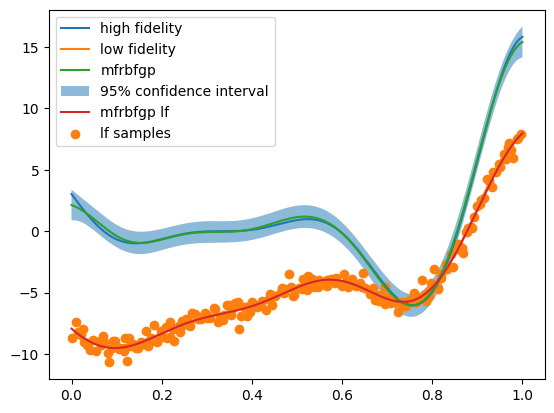

In [8]:
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y2, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y2 - 1.96 * mfrbfgp_pred_std2).flatten(),
    (mfrbfgp_pred_y2 + 1.96 * mfrbfgp_pred_std2).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly2, label="mfrbfgp lf")
ax.scatter(sample_x["lf"], sample_y2["lf"], label="lf samples")
# ax.scatter(sample_x["lf"], sample_y_1a["lf"], label="lf samples")
ax.legend()
plt.show()

In [9]:
# add more noise to the low fidelity
noise_add_3 = 1.0
sample_y3 = sample_y1.copy()
sample_y3["lf"] = func.lf(sample_x["lf"]) + np.random.normal(
    0, noise_add_3, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

In [10]:
# train the model
mfrbfgp3 = MFRBFGPR(
    design_space=func.input_domain, noise_prior=None, optimizer_restart=optimizer_restart
)
mfrbfgp3.train(samples=sample_x, responses=sample_y3)

mfrbfgp_pred_y3, mfrbfgp_pred_std3 = mfrbfgp3.predict(
    x_predict=test_x, return_std=True)
# get prediction of low fidelity
pred_ly3 = mfrbfgp3.predict_lf(test_xl=test_x)

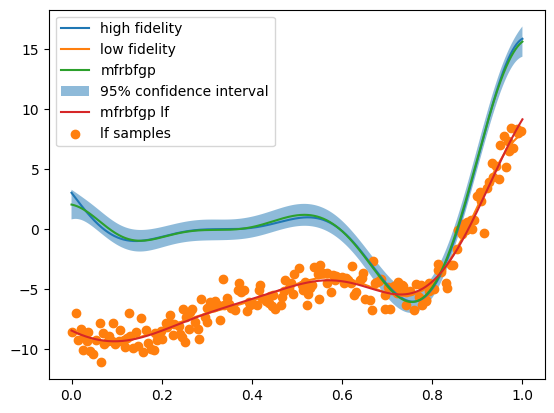

In [11]:
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y3, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y3 - 1.96 * mfrbfgp_pred_std3).flatten(),
    (mfrbfgp_pred_y3 + 1.96 * mfrbfgp_pred_std3).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly3, label="mfrbfgp lf")
ax.scatter(sample_x["lf"], sample_y3["lf"], label="lf samples")
# ax.scatter(sample_x["lf"], sample_y_1a["lf"], label="lf samples")
ax.legend()
plt.show()

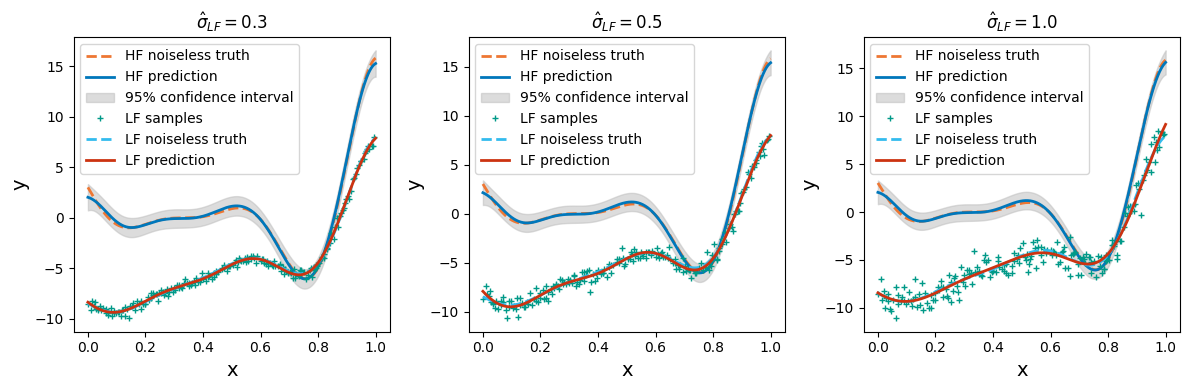

In [12]:
# plot comparison for different noise
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(test_x, test_hy, "--", color="#EE7733",
           linewidth=2, label="HF noiseless truth")
ax[0].plot(test_x, mfrbfgp_pred_y1, "-", color="#0077BB",
           linewidth=2, label="HF prediction")
ax[0].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y1 - 1.96 * mfrbfgp_pred_std1).flatten(),
    (mfrbfgp_pred_y1 + 1.96 * mfrbfgp_pred_std1).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label=r"95% confidence interval",
)
ax[0].plot(sample_x["lf"], sample_y1["lf"], '+',
           linewidth=2,
           markersize=5,
           color="#009988", label="LF samples")
ax[0].plot(test_x, test_ly, "--", color="#33BBEE",
           linewidth=2, label="LF noiseless truth")
ax[0].plot(test_x, pred_ly1, "-", color="#CC3311",
           linewidth=2, label="LF prediction")

ax[0].legend()
ax[0].set_title(r"$\hat{\sigma}_{LF}= 0.3$")
ax[0].set_xlabel("x", fontsize=14)
ax[0].set_ylabel("y", fontsize=14)
#
ax[1].plot(test_x, test_hy, "--", color="#EE7733",
           linewidth=2, label="HF noiseless truth")
ax[1].plot(test_x, mfrbfgp_pred_y2, "-", color="#0077BB",
           linewidth=2, label="HF prediction")
ax[1].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y2 - 1.96 * mfrbfgp_pred_std2).flatten(),
    (mfrbfgp_pred_y2 + 1.96 * mfrbfgp_pred_std2).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label=r"95% confidence interval",
)
ax[1].plot(sample_x["lf"], sample_y2["lf"], '+',
           linewidth=2,
           markersize=5,
           color="#009988", label="LF samples")
ax[1].plot(test_x, test_ly, "--", color="#33BBEE",
           linewidth=2, label="LF noiseless truth")

ax[1].plot(test_x, pred_ly2, "-", color="#CC3311",
           linewidth=2, label="LF prediction")
ax[1].legend()
ax[1].set_title(r"$\hat{\sigma}_{LF}= 0.5$")
ax[1].set_xlabel("x", fontsize=14)
ax[1].set_ylabel("y", fontsize=14)
#
ax[2].plot(test_x, test_hy, "--", color="#EE7733",
           linewidth=2, label="HF noiseless truth")
ax[2].plot(test_x, mfrbfgp_pred_y3, "-", color="#0077BB",
           linewidth=2, label="HF prediction")
ax[2].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y3 - 1.96 * mfrbfgp_pred_std3).flatten(),
    (mfrbfgp_pred_y3 + 1.96 * mfrbfgp_pred_std3).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label=r"95% confidence interval",
)
ax[2].plot(sample_x["lf"], sample_y3["lf"], '+',
           linewidth=2,
           markersize=5,
           color="#009988", label="LF samples")
ax[2].plot(test_x, test_ly, "--", color="#33BBEE",

           linewidth=2, label="LF noiseless truth")

ax[2].plot(test_x, pred_ly3, "-", color="#CC3311",
           linewidth=2, label="LF prediction")
ax[2].legend()
ax[2].set_title(r"$\hat{\sigma}_{LF}= 1.0$")
ax[2].set_xlabel("x", fontsize=14)
ax[2].set_ylabel("y", fontsize=14)
plt.tight_layout()
plt.savefig("different_noise_influence.png", dpi=300)
plt.savefig("different_noise_influence.pdf", dpi=300)
plt.savefig("different_noise_influence.svg", dpi=300)
plt.show()

In [13]:
# calculate mse, mae, r2 score and log marginal likelihood for different noise
# mse
import pandas as pd
mse_1 = mean_squared_error(test_hy, mfrbfgp_pred_y1)
mse_2 = mean_squared_error(test_hy, mfrbfgp_pred_y2)
mse_3 = mean_squared_error(test_hy, mfrbfgp_pred_y3)

# mae
mae_1 = mean_absolute_error(test_hy, mfrbfgp_pred_y1)
mae_2 = mean_absolute_error(test_hy, mfrbfgp_pred_y2)
mae_3 = mean_absolute_error(test_hy, mfrbfgp_pred_y3)

# r2 score
r2_1 = r2_score(test_hy, mfrbfgp_pred_y1)
r2_2 = r2_score(test_hy, mfrbfgp_pred_y2)
r2_3 = r2_score(test_hy, mfrbfgp_pred_y3)

# log marginal likelihood
logp_1 = calculate_log_marginal_likelihood_mf(mfrbfgp1, test_x, test_hy_noisy)
logp_2 = calculate_log_marginal_likelihood_mf(mfrbfgp2, test_x, test_hy_noisy)
logp_3 = calculate_log_marginal_likelihood_mf(mfrbfgp3, test_x, test_hy_noisy)

print("mse: ", mse_1, mse_2, mse_3)
print("mae: ", mae_1, mae_2, mae_3)
print("r2: ", r2_1, r2_2, r2_3)
print("logp: ", logp_1, logp_2, logp_3)

# save the results to pandas dataframe
df = pd.DataFrame(columns=["mse", "mae", "r2", "logp", "noise"])
df.loc["noise_0.3"] = [mse_1, mae_1, r2_1, logp_1, mfrbfgp1.noise]
df.loc["noise_0.5"] = [mse_2, mae_2, r2_2, logp_2, mfrbfgp2.noise]
df.loc["noise_1.0"] = [mse_3, mae_3, r2_3, logp_3, mfrbfgp3.noise]
print(df)
df.to_csv("different_noise_influence.csv")

mse:  0.03373284290282028 0.0309718138398446 0.031484898649787964
mae:  0.1324506519016927 0.13091919264191487 0.1304843447965352
r2:  0.9983099253393714 0.9984482577434927 0.9984225512935935
logp:  569.6817861793027 578.9896420715754 583.3582400471556
                mse       mae        r2        logp     noise
noise_0.3  0.033733  0.132451  0.998310  569.681786  0.332479
noise_0.5  0.030972  0.130919  0.998448  578.989642  0.322901
noise_1.0  0.031485  0.130484  0.998423  583.358240  0.316334
